C:\Users\Lokesh\AppData\Local\Temp\ipykernel_29944\3237414697.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100.0111162325926' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "SoC_CC (%)"] = max(0, df.loc[i - 1, "SoC_CC (%)"] - (dQ / Q_nominal) * 100)


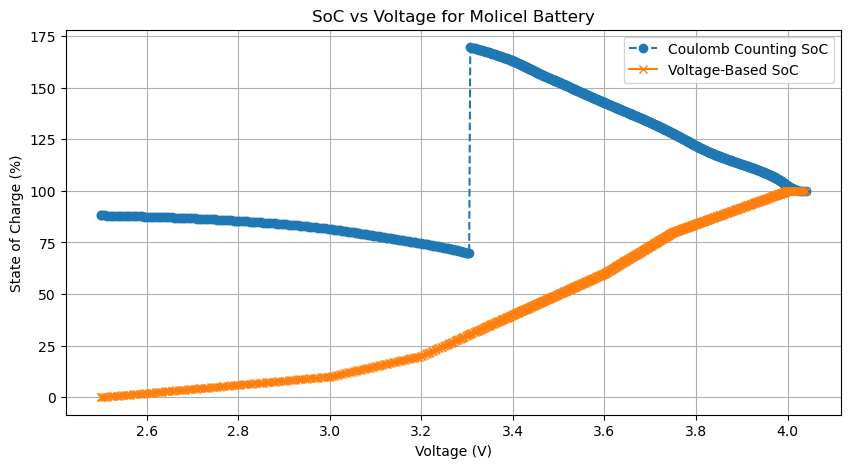

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load dataset
file_path = "Battery_Data_Final_Corrected.csv"  # Adjust path if necessary
df = pd.read_csv(file_path)

# Auto-detect time format
def parse_time(time_str):
    try:
        return pd.to_datetime(time_str, format="%H:%M:%S.%f")  # Format with milliseconds
    except ValueError:
        try:
            return pd.to_datetime(time_str, format="%M:%S.%f")  # Format without hours
        except ValueError:
            return pd.to_datetime(time_str, format="%M:%S")  # Format without milliseconds

df["Time"] = df["Time"].astype(str).apply(parse_time)  # Convert time column
df["Time_s"] = (df["Time"] - df["Time"].iloc[0]).dt.total_seconds()  # Convert to seconds

# Battery Parameters for Molicel
Q_nominal = 4.5 * 3600  # Convert 4.5Ah to Coulombs (Ah -> As)
df["SoC_CC (%)"] = 100  # Initialize SoC at 100%

# Compute SoC using Coulomb Counting
for i in range(1, len(df)):
    dt = df["Time_s"].iloc[i] - df["Time_s"].iloc[i - 1]  # Time difference in seconds
    current = df["Current (mA)"].iloc[i] / 1000  # Convert mA to A
    dQ = current * dt  # Charge change in Coulombs
    df.loc[i, "SoC_CC (%)"] = max(0, df.loc[i - 1, "SoC_CC (%)"] - (dQ / Q_nominal) * 100)

# Updated Voltage-to-SoC Mapping for Molicel
voltage_soc_map = {
    2.5: 0,  
    3.0: 10,
    3.2: 20,
    3.4: 40,
    3.6: 60,  
    3.75: 80,  
    4.0: 100
}

# Interpolation function
interp_func = interp1d(list(voltage_soc_map.keys()), list(voltage_soc_map.values()), kind='linear', fill_value="extrapolate")

# Compute SoC using Voltage
df["SoC_Voltage (%)"] = np.clip(interp_func(df["Ecell (V)"]), 0, 100)

# Plot SoC vs Voltage
plt.figure(figsize=(10, 5))
plt.plot(df["Ecell (V)"], df["SoC_CC (%)"], label="Coulomb Counting SoC", linestyle="--", marker="o")
plt.plot(df["Ecell (V)"], df["SoC_Voltage (%)"], label="Voltage-Based SoC", linestyle="-", marker="x")

plt.xlabel("Voltage (V)")
plt.ylabel("State of Charge (%)")
plt.title("SoC vs Voltage for Molicel Battery")
plt.legend()
plt.grid(True)
plt.show()
